#Functions

Nem kell kinyitni, csak " ▶ "

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px #gui 3d scatterplot
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import csv

def rotate_nov_get_MTX(nov, leave_out):

  # "nov": everything is aligned to this
  # w = ([x0, x1, ...], [y0, y1, ...], [z0, z1, ...])

  # first rotating around Y axis
  # we have to define the angle of rotation
  # we project everything to xz plane 
  # the slope of the electrode is observed 
  # slope is derived from interpolation 
  nov = np.array(nov)

  for e in leave_out:
    nov.pop(e)

  eqy = np.polyfit(nov[0],nov[2],1)
  alphay = np.arctan(eqy[0])
  Ty = np.array([[np.cos(alphay), 0, np.sin(alphay)],  [0, 1, 0], [-np.sin(alphay), 0, np.cos(alphay)]])

  # rotation with matrix multiplying
  W = np.matmul(Ty, nov)
  # "nov" is in the xy plane

  # let's do a rotation around the z axis
  # we need the angle of rotation as well

  eqz = np.polyfit(W[0],W[1],1)  
  alphaz = -np.arctan(eqz[0])
  Tz = np.array([[np.cos(alphaz), -np.sin(alphaz), 0], [np.sin(alphaz), np.cos(alphaz), 0], [0, 0, 1]])

  W = np.matmul(Tz, W) # this will be "nov"
  W = list(W)
  for i in range(len(W)):
    W[i] = list(W[i])
  return [W, Ty, Tz]

def translate(nov):
  m_x = min(nov[0])
  m_y = nov[1][0]
  m_z = nov[2][0]
  for i in range(len(nov[0])):
    nov[0][i] = nov[0][i] - m_x
    nov[1][i] = 0
    nov[2][i] = 0
  return [nov, m_x, m_y, m_z]

def rotate_translate_cell(crd, Ty, Tz, m_x, m_y, m_z):
  # rotating the cell:
  crd = np.array(crd)
  # transposing:
  crd = np.transpose(crd)
  # spatial coords are cut down:
  crd1 = crd[:3]
  # diameters:
  crd2 = crd[-1]

  CRD = np.matmul(Ty, crd1)
  CRD = np.matmul(Tz, CRD)
  CRD[0] = CRD[0] - m_x
  CRD[1] = CRD[1] - m_y
  CRD[2] = CRD[2] - m_z
  CRD = np.append(CRD, [crd2], axis=0)
  CRD = np.transpose(CRD)
  # type conversion into Python list
  CRD = list(CRD)
  for i in range(len(CRD)):
    CRD[i] = list(CRD[i])
  return CRD

def find_slice_bdy(nov):
  slice_bdy = []
  for i in range(len(nov[0])-1):
    slice_bdy.append((nov[0][i] + nov[0][i+1])/2)
  return slice_bdy

def dist(v1, v2):
  '''
  Distance function
  Input: two points from R^n
  Returns: Eucledian distance of first 3 coords of two arrays in $\mu m$
  '''
  dx = (v1[0] - v2[0]) ** 2    
  dy = (v1[1] - v2[1]) ** 2
  dz = (v1[2] - v2[2]) ** 2
  return (dx + dy + dz) ** 0.5

def dist_Ness(v1, v2):
  '''
  Distance function for MIRROR IMAGE CHARGES
  Input: two points from R^n
  Returns: Eucledian distance of first 3 coords of two arrays in $\mu m$
  '''
  dx = (v1[0] - v2[0]) ** 2    
  dy = (v1[1] - v2[1]) ** 2
  dz = (v1[2] - v2[2] + 50) ** 2
  return (dx + dy + dz) ** 0.5

def surface(v1, v2):
  '''
  Surface function
  Input: two points from R^n
  dist function for each points -> length
  the 4th data in each spatial point list is the diameter
  Returns: surface of a truncated cone 
  units are the same as before
  '''
  length = dist(v1,v2)  
  r1 = v1[3]/2  
  r2 = v2[3]/2  
  return (r1 + r2) * np.pi * np.sqrt(length**2 + (r1 - r2)**2)

def resistance(v1, v2, sigma):
  '''
  Resistance function
  Input: two points from R^n
  executes the dist method on each points-> l
  the 4th data in each point is the diameter
  Visszaad: resistance of a truncated cone
  '''
  l = dist(v1,v2)
  r1 = v1[3]/2
  r2 = v2[3]/2
  return l / (sigma * r1 * r2 * pi)  

#########################################
############ -- CUT CELL -- #############
#########################################

def cut_cell(coords, nov):
  l, co = [], []
  switch = True
  while switch:
    switch = False
    for c in range(len(coords)-1):

      for electrode in nov:  # ex. electrode = (0,0,0)
        if coords[c][0] < electrode < coords[c+1][0]:
          l.append(c+1) # indices of new coordinate
          xe = electrode
          X = [coords[c][0], coords[c+1][0]]
          Y = [coords[c][1], coords[c+1][1]]
          Z = [coords[c][2], coords[c+1][2]]
          t = (xe - X[0]) / (X[1] - X[0])
          d_new = (coords[c+1][3] - coords[c][3]) * t + coords[c][3]
          new_point = (xe, (Y[1]-Y[0]) * t + Y[0],(Z[1]-Z[0]) * t + Z[0], d_new)
          co.append(new_point) # new coordinate

    l.reverse()  # to have the right order of indices
    co.reverse() # here too

    # putting new coordinates inbtw real coordinates
    for i in range(len(l)):
      coords.insert(l[i], co[i])

    l, co = [], []  

    # execute from inverse direction:
    for c in range(len(coords)-1):
      for electrode in reversed(nov):  # ex. electrode = (0,0,0)
        if coords[c][0] > electrode > coords[c+1][0]:
          switch = False
          l.append(c+1)
          xe = electrode
          X = [coords[c][0], coords[c+1][0]]
          Y = [coords[c][1], coords[c+1][1]]
          Z = [coords[c][2], coords[c+1][2]]
          t = (xe - X[0]) / (X[1] - X[0])
          d_new = (coords[c+1][3] - coords[c][3]) * t + coords[c][3]
          new_point = (xe, (Y[1]-Y[0]) * t + Y[0],(Z[1]-Z[0]) * t + Z[0], d_new)
          co.append(new_point)

    l.reverse()
    co.reverse()
    for i in range(len(l)):
      coords.insert(l[i], co[i])

  return coords

#########################################
#########################################

#########################################
######### -- TAG INTERVALS -- ###########
#########################################

def tag_intervals(cellpart, nov):
  for i in range(len(cellpart["coords"]) - 1):
    x1 = cellpart["coords"][i][0]
    x2 = cellpart["coords"][i+1][0]

    if nov[-1] <= x1 and nov[-1] <= x2:
      cellpart["slice"].append(len(nov))
    else:
      for j in range(len(nov)):  # novel[i] = [0,0,0]
        if x1 <= nov[j] and x2 <= nov[j]:
          cellpart["slice"].append(j)
          break

#########################################
#########################################

#########################################
######## -- CALCULATE PARAMETERS -- #########
#########################################

def calculate_parameters(cellpart):
  for i in range(len(cellpart["coords"]) - 1):
    v1 = cellpart["coords"][i]
    v2 = cellpart["coords"][i+1]
    cellpart["surface"].append(surface(v1,v2))
    #cellpart["resistance"].append(resistance(v1, v2, sigma))
    cellpart["length"].append(dist(v1, v2))

def calculate_resistance(cellpart):
  for i in range(len(cellpart["coords"]) - 1):
    v1 = cellpart["coords"][i]
    v2 = cellpart["coords"][i+1]
    cellpart["resistance"].append(resistance(v1, v2, sigma))

#########################################
#########################################

#########################################
########### -- INTEGRAL -- ##############
#########################################

def calculate_integral(cellpart, CSD, Vconst):
  # CSD is the  proper row of csd

  # previous cell compartment
  prev_cell = cellpart["prev"]
  # integraal until the prev. compartment
  if prev_cell == "CellBody":

    ## first integrating method
    prev_int_1 = 0      #S_soma kene?  #----------------> I_ax(0,t) nincs, mert szooma
    prev_int_2 = Vconst 

    ## new integrating method
    #S = Cell['CellBody']['surface'][0]
    #index = Cell['CellBody']['slice'][0]
    #R = Cell['CellBody']["resistance"][0]
    #prev_int_1_from_soma = S * CSD[index]
    #prev_int_2_from_soma = Vconst      #+ R * prev_int_1_from_soma
  
  else:
    ## first integrating method
    prev_int_1 = Cell[prev_cell]["first_integral"][-1]
    prev_int_2 = Cell[prev_cell]["second_integral"][-1]

    ## new integrating method
    #prev_int_1_from_soma = Cell[prev_cell]["first_integral_from_soma"][-1]
    #prev_int_2_from_soma = Cell[prev_cell]["second_integral_from_soma"][-1]

  for i in range(len(cellpart["slice"])):
    C1 = cellpart["coords"][i]
    C2 = cellpart["coords"][i+1]
    S = cellpart["surface"][i]
    R = cellpart["resistance"][i]
    index = cellpart["slice"][i]

    ## first integrating method
    prev_int_1 += S * CSD[index]  #S = surface
    prev_int_2 += R * prev_int_1  #R = Resistance       #<-------------

    ## new integrating convention
    #prev_int_1_from_soma += S * CSD[index] #S = surface
    #prev_int_2_from_soma += R * prev_int_1_from_soma #R = Resistance

    cellpart["first_integral"].append(prev_int_1)
    cellpart["second_integral"].append(prev_int_2)
    
    #cellpart["first_integral_from_soma"].append(prev_int_1_from_soma)
    #cellpart["second_integral_from_soma"].append(prev_int_2_from_soma)


# ------------------------ EZ A JÓ ---------------------------

def calculate_rev_integral(name, cellpart, CSD):

  prev1 = check_prev(Cell, name + '-1')
  prev2 = check_prev(Cell, name + '-2')
  prev_int_1 = prev1[0] + prev2[0]
  prev_int_2 = 0
  #prev_int_2 = prev1[1]+prev2[1]
  #print('prev_int_1,prev_int_2')
  #print([prev_int_1,prev_int_2])

  for i in reversed(range(len(cellpart["slice"]))):
    C2 = cellpart["coords"][i] # ez is változott
    C1 = cellpart["coords"][i+1]
    S = cellpart["surface"][i]
    R = cellpart["resistance"][i]
    index = cellpart["slice"][i]
    #print('C1, C2, S, R, index')
    #print([C1, C2, S, R, index])

    prev_int_1 += S * CSD[index]  #S = surface
    prev_int_2 += R * prev_int_1  #R = Resistance       #<-------------

    cellpart["f_int"].insert(0, prev_int_1)
    cellpart["s_int"].insert(0, prev_int_2)

def correct_integral(part):
  prev = Cell[part]["prev"]
  delta = Cell[part]["s_int"][0] - Cell[prev]["s_int"][-1]
  for i in range(len(Cell[part]["s_int"])):
    Cell[part]["s_int"][i] -= delta

def correct_integral_regi(part, VS_dict):
  name = part.split('_')[0]
  delta = VS_dict[name]
  for i in range(len(Cell[part]["s_int"])):
    Cell[part]["s_int"][i] += delta

def check_prev(dic, key):
  if key in dic.keys():
    return [dic[key]["f_int"][0],dic[key]["s_int"][0]] # ezt javítottam
  else:
    return [0, 0]

def reset_cell(cellpart):
  cellpart["first_integral"] = []
  cellpart["second_integral"] = []
  cellpart["f_int"] = []
  cellpart["s_int"] = []

def reset_cell_resistence(cellpart):
  cellpart["resistance"] = []
  
def calculate_center(coords):
  coords = np.transpose(np.array(coords))
  center = [0,0,0]
  center[0] = sum(coords[0])/len(coords[0])
  center[1] = sum(coords[1])/len(coords[1])
  center[2] = sum(coords[2])/len(coords[2])
  return center

# BEOLVAS 1
# $V_c∈𝐑^{200}$ membrane constant
This is measured with patch clamp

In [ ]:
Vc = []
with open("Vic.csv", 'r') as file:
  csvreader = csv.reader(file)
  for row in csvreader:
    Vc.append(float(row[0]))

#eddig itt oldottuk meg a mV --> uV konverziót
#for i in range(len(Vc)): #conversion mV --> uV
#  Vc[i] = 1000* Vc[i]

print(Vc)

[-33.254566865957464, -33.05348566648936, -33.11079012553189, -33.04641467925534, -33.08352397021281, -33.25215630212767, -33.11869141808516, -33.10160319893619, -33.07256929680852, -33.0882379617021, -33.1589411380319, -33.135110036170246, -33.107596128457445, -33.11234360000002, -32.94746103404254, -33.06820349787233, -33.00389501170211, -32.9733344191489, -33.0719934398936, -33.05593640638296, -33.02671501595749, -32.919980606383014, -32.975450358510656, -33.050579597872336, -33.002154048936184, -33.200623804255365, -33.217229910638274, -33.123030432978716, -33.025536518085126, -33.11865124202129, -33.096942775531936, -33.082760625000006, -33.211953454255315, -33.109558059574475, -33.14735034361702, -33.15554626063834, -33.27178900531921, -33.32342863936173, -33.34646291595747, -33.08025631702129, -33.1535374574468, -33.22598829255319, -33.01918869999999, -33.2135872808511, -33.299242648936186, -33.25895944893617, -33.376836020212785, -33.217069206382966, -33.260981644148934, -33.27

# BEOLVAS 2
#NEW $V_{EC}\in \mathbb{R}^{29\times40000}$

**át kell nevezni a fájlt .txt-re, csv-vel valami miatt nem ment**

`V_ec = np.array([[...],[...],[...],...,[...]])`

In [ ]:
V_ec = []

for line in open("Vec.txt"):
  line = line.split(",")
  for i in range(len(line)):
    line[i] = float(line[i])
  V_ec.append(line)

V_ec = np.transpose(np.array(V_ec))

print(len(V_ec))
print(len(V_ec[0]))

#Electrode array contact points, $novel ∈𝐑^{32\times3}$
3 spatial coordinates and 32 spikes,
not transposed but interpolated

In [ ]:
# index vector for damaged contact points
leave_out = [0,30,31]
leave_out.sort(reverse=True)

novel_raw = [[-1820.237     , -1811.49912903, -1802.76125806, -1794.0233871 ,
        -1785.28551613, -1776.54764516, -1767.80977419, -1759.07190323,
        -1750.33403226, -1741.59616129, -1732.85829032, -1724.12041935,
        -1715.38254839, -1706.64467742, -1697.90680645, -1689.16893548,
        -1680.43106452, -1671.69319355, -1662.95532258, -1654.21745161,
        -1645.47958065, -1636.74170968, -1628.00383871, -1619.26596774,
        -1610.52809677, -1601.79022581, -1593.05235484, -1584.31448387,
        -1575.5766129 , -1566.83874194, -1558.10087097, -1549.363     ],
       [-1201.963     , -1180.00526774, -1158.04753548, -1136.08980323,
        -1114.13207097, -1092.17433871, -1070.21660645, -1048.25887419,
        -1026.30114194, -1004.34340968,  -982.38567742,  -960.42794516,
         -938.4702129 ,  -916.51248065,  -894.55474839,  -872.59701613,
         -850.63928387,  -828.68155161,  -806.72381935,  -784.7660871 ,
         -762.80835484,  -740.85062258,  -718.89289032,  -696.93515806,
         -674.97742581,  -653.01969355,  -631.06196129,  -609.10422903,
         -587.14649677,  -565.18876452,  -543.23103226,  -521.2733    ],
       [ -112.5167    ,  -117.18444194,  -121.85218387,  -126.51992581,
         -131.18766774,  -135.85540968,  -140.52315161,  -145.19089355,
         -149.85863548,  -154.52637742,  -159.19411935,  -163.86186129,
         -168.52960323,  -173.19734516,  -177.8650871 ,  -182.53282903,
         -187.20057097,  -191.8683129 ,  -196.53605484,  -201.20379677,
         -205.87153871,  -210.53928065,  -215.20702258,  -219.87476452,
         -224.54250645,  -229.21024839,  -233.87799032,  -238.54573226,
         -243.21347419,  -247.88121613,  -252.54895806,  -257.2167    ]]

# Transposing electrode array contact sites
We rotate and translate the electrode to the x axes.

In [ ]:
##### - TRANSPOSE NOVEL - #####

novel, Ty, Tz = rotate_nov_get_MTX(novel_raw)
'''
print("novel_raw: \n")
for line in novel_raw:
  print(line)
print(50*"--" + "\n")
print("novel: \n")
for line in novel:
  print(line)
print(50*"--" + "\n")
'''
novel, m_x, m_y, m_z = translate(novel)
'''
print("novel after rotation and translation: \n")
for line in novel:
  print(line)
print(50*"--" + "\n")

print("Rotation matrices: \n")
print("Ty:")
print(Ty)
print("Tz:")
print(Tz)
'''
slice_bdy = find_slice_bdy(novel)

#Reading cell morphology & building up cell dict

In [ ]:
#Read cell file into a list
#https://drive.google.com/file/d/1Tgcfnf3IMl4afCxFI38EQCgp7qIiVf_F/view?usp=sharing
filename = "sp9_whole_cell.txt"

cd_temp = []
N=0
for line in open(filename):
  line = line.translate({ord(';'): None })
  line = line.strip(',\n "')
  line = line.split(" ")
  cd_temp.append(line)


# We construct a structure file, which indices the cell compartments properly
struct = []
a, d, c, ap, t = 0, 0, 0, 0, 0
for l in range(len(cd_temp)):
  if cd_temp[l][0] == "Axon":
    t = "ax-" + str(a) + "_"
    struct.append([l, a, t + 'R'])
    a += 1
  elif cd_temp[l][0] == "Dendrite":
    t = "d-" + str(d) + "_"
    struct.append([l, d, t + 'R'])
    d += 1
  elif cd_temp[l][0] == "CellBody":
    struct.append([l, c, 'CellBody'])
    t = c
    c += 1
  elif cd_temp[l][0] == "Apical":
    t = "ap-" + str(ap) + "_"
    struct.append([l, ap, t + 'R'])
    ap += 1
  elif len(cd_temp[l][-1]) > 1 and cd_temp[l][-1][0] == "R" and cd_temp[l][-1] != "Red" and cd_temp[l][-1] != "Root" :
    struct.append([l, t, t + cd_temp[l][-1]])
struct.append([len(cd_temp), 'X', 'End'])


Cell = {}
Map = []
min_x = 0
min_y = 0
min_z = 0
for s in range(len(struct)-1):
  test = struct[s][2].split("_")
  if test[0] == 'CellBody':
    prev = 'X'
    l = []
  elif test[1] == 'R':
    prev = 'CellBody'
    l = []
  else:
    size = len(test[1])
    # Slice string to remove last 2 characters from string
    test[1] = test[1][:size - 2]
    prev = test[0] + "_" + test[1]
    l = [Cell[prev]["coords"][-1]] # new cellcompartment begins at the end of prev one!
  for i in range(struct[s][0], struct[s+1][0]):
    num = cd_temp[i][0].translate({ord('.'): None })
    num = num.translate({ord('-'): None })
    if num.isnumeric():
        l.append(
            [float(cd_temp[i][0]),
            float(cd_temp[i][1]),
            float(cd_temp[i][2]),
            float(cd_temp[i][3])]
            )
        
  Cell.update({struct[s][2] : {
      "prev" : prev,
      "coords" : l,
      "length" : [],
      "surface" : [],
      "slice" : [],
      "first_integral" : [],
      "second_integral" : [],
      "first_integral_from_soma" : [],
      "second_integral_from_soma" : [],
      "f_int" : [],
      "s_int" : [],
      "resistance" : []
    }})
  Map.append(struct[s][2])

Bdy_center = calculate_center(Cell['CellBody']['coords'])
Bdy_center.append(25)
Cell['CellBody']['coords'] = [Bdy_center]

Map.sort()


##### - CALCULATE LEVELS - #####
m = 0
for i in range(len(Map)):
  if m < Map[i].count('-'):
    m = Map[i].count('-')

Lvl_Map = [[] for i in range(m+1)]

for i in range(len(Map)):
  Lvl_Map[Map[i].count('-')].append(Map[i])


##### - CELL TRANSFORMATION - #####
for part in Map:
  Cell[part]["coords"] = rotate_translate_cell(Cell[part]["coords"], Ty, Tz, m_x, m_y, m_z)


##### - CELL SLICING - #####
# along novel
for part in Map:
  Cell[part]["coords"] = cut_cell(Cell[part]["coords"], slice_bdy)


##### - CELL PARAMETERS - NOT RESISTANCE - #####
for part in Map:
  if part != 'CellBody':
    calculate_parameters(Cell[part])
  else:
    # (!)
    Cell['CellBody']['surface'] = [4 * (Cell['CellBody']['coords'][0][3]/2)**2 * np.pi]
    Cell['CellBody']['length'] = 20


##### - TAGGING INTERVALS ACCORDING TO SLICE - #####
for part in Map:
  tag_intervals(Cell[part], slice_bdy)
Cell["CellBody"]["slice"] = [6]

##### - CALCULATE TOTAL SURFACES IN SLICES - #####
surf_in_slice = np.zeros(len(novel[0])) # total surfaces in slices
surf_avg = np.zeros(len(novel[0])) # ezt nem tudom miért kell külön

for part in Map:
  for i in range(len(Cell[part]['slice'])):
    s = Cell[part]['slice'][i]  # slice index
    surf_in_slice[s] += Cell[part]['surface'][i] #cumsum of the surfaces in a slice
    surf_avg[s] += Cell[part]['surface'][i] #cumsum of the surfaces in a slice


# Parameters & **RUN**

[[ 4.51979132e-07  8.90618549e-08 -1.40476435e-07 ... -7.49946111e-10
  -1.89651959e-09 -3.38423595e-09]
 [-3.43475341e-08  1.78984626e-07  1.56088315e-07 ... -9.49175101e-10
  -1.58281424e-09 -1.84770763e-09]
 [-1.18377092e-07  7.25924657e-08  1.83021991e-07 ... -5.70161295e-10
  -9.67806709e-10 -1.17379306e-09]
 ...
 [-1.17582622e-09 -1.13851896e-09 -1.00063755e-09 ...  1.91205487e-07
   2.94934333e-08 -2.06682004e-07]
 [-1.08519328e-09 -1.20843259e-09 -1.06524721e-09 ...  1.78336175e-07
   1.32710878e-07 -1.36521354e-07]
 [-1.44324755e-09 -2.01392061e-09 -1.80951562e-09 ... -1.15760932e-07
   7.43257906e-08  3.77083394e-07]]
max = 36300.51007146125
min = -83071.52565302496


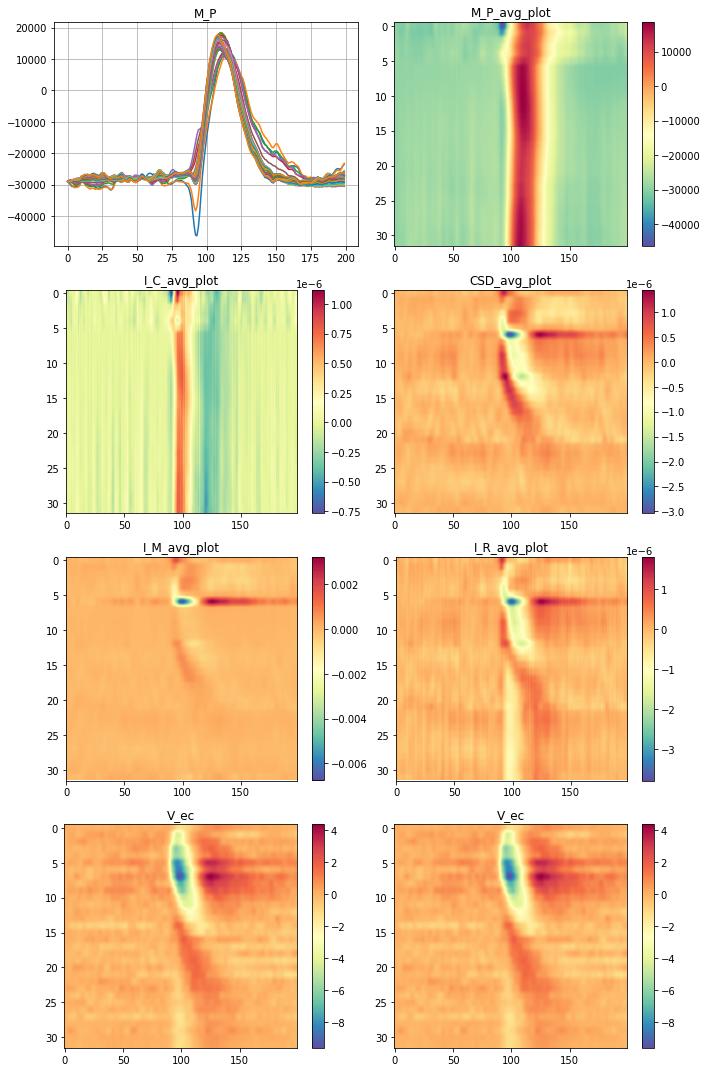

In [ ]:
alpha = (3.8*10**11)**(1/2)
sigma = 5e-6 #2e-6 #S/um   50 Ohm * cm 19691.  1.18e-7

pi = np.pi
sigma_ec = 3e-7 #S/um     
capacity = .9e-14   #F/um^2  = C_m
sigma_sal = 15e-7 #S/um  
W_ts = (sigma_ec-sigma_sal)/(sigma_ec+sigma_sal)
dt = 5 * 1e-5  # [dt] = 1/20 kHz (time step size)

##### - RESISTANCE - #####
for part in Map:
  if part != 'CellBody':
    reset_cell_resistence(Cell[part])
    calculate_resistance(Cell[part])
  else:
    Cell['CellBody']['resistance'] = [Cell['CellBody']['length'] /((Cell['CellBody']['coords'][0][3]/2)**2 * pi * sigma)]

##### - TRANSFERMATRIX - #####
T = np.zeros((32,32))
avg = []
for part in Map:
  if part != 'CellBody':
    for s in range(len(Cell[part]["slice"])):
      i = Cell[part]["slice"][s]
      surf = Cell[part]["surface"][s]
      x1 = Cell[part]["coords"][s]
      x2 = Cell[part]["coords"][s+1]
      avg = [(x1[0]+x2[0])/2, (x1[1]+x2[1])/2, (x1[2]+x2[2])/2] 

      for j in range(len(novel[0])):
          #T[i,j] += surf/dist(avg, [novel[0][j], novel[1][j], novel[2][j]])
          T[i,j] += (surf/dist(avg, [novel[0][j], novel[1][j], novel[2][j]]))+(W_ts*surf/dist_Ness(avg, [novel[0][j], novel[1][j], novel[2][j]]))

  else: #Cell Body
    # We include the soma
    i = Cell[part]["slice"][0]
    surf = Cell[part]["surface"][0]
    center = Cell[part]["coords"][0]
    for j in range(len(novel[0])):
      #T[i,j] += surf/dist(center, [novel[0][j], novel[1][j], novel[2][j]])
      T[i,j] += (surf/dist(center, [novel[0][j], novel[1][j], novel[2][j]]))+(W_ts*surf/dist_Ness(center, [novel[0][j], novel[1][j], novel[2][j]]))

T = (1/(4*pi*sigma_ec))*T

T = np.transpose(T)

##### - REGULARIZATION - #####
T_reg = np.matmul(np.linalg.inv(np.matmul(np.transpose(T), T) + alpha**2*np.identity(32)),np.transpose(T))
print(T_reg)

##### - siCSD - #####
csd = list(np.transpose(np.matmul(T_reg,V_ec)))


##### - INTEGRAL => membrane potential - #####
M_P = []  #*
M_P_avg = []   #*

for i in range(len(csd)): # for all time instances
  membrane_pot = []
  membrane_pot_avg = [0]*len(novel[0])
  
  for lvl in reversed(Lvl_Map):
    for part in lvl:
      if part != 'CellBody':
        calculate_rev_integral(part, Cell[part], csd[i]) #be lehetne tenni az alatta levo for part in Map ciklusba
      elif part == 'CellBody':
        Cell["CellBody"]['s_int'] = [Vc[i]]
  
  for lvl in Lvl_Map:
    for part in lvl:
      if part != 'CellBody':
        correct_integral(part)
  
  '''
  VS_dict = {}
  for part in Lvl_Map[1]:
    #print(part)
    #print(Cell[part]['s_int'][-1])
    p = part.split('_')[0]
    VS_dict[p] = Vc[i] - Cell[part]['s_int'][0]
  
  for lvl in reversed(Lvl_Map):
    for part in lvl:
      if part != 'CellBody':
        correct_integral(part, VS_dict)
  '''  

  for part in Map: # ez csak felépíti az ábrázolható anyagot
    if part != 'CellBody':
      for q in range(len(Cell[part]["slice"])):
        C1 = Cell[part]["coords"][q]
        C2 = Cell[part]["coords"][q+1]
        S = Cell[part]["surface"][q]
        R = Cell[part]["resistance"][q]
        index = Cell[part]["slice"][q]
        integral2 = Cell[part]["s_int"][q] #but this is not div by total surface per slice
        membrane_pot.append([C1, C2, integral2, index, S])
        membrane_pot_avg[index] += integral2 * S / surf_in_slice[index] #DIV BY TOTAL SURFACE PER SLICE
  
  C1 = Cell["CellBody"]["coords"][0]
  integral2 = Cell["CellBody"]["s_int"][0]
  S = Cell["CellBody"]["surface"][0]
  index = Cell["CellBody"]["slice"][0]
  membrane_pot.append([C1, C1, integral2, index, S])
  membrane_pot_avg[index] += integral2 * S / surf_in_slice[index] 

  M_P.append(membrane_pot)
  M_P_avg.append(membrane_pot_avg)

  for part in Map:
    reset_cell(Cell[part])

min = 0
max = 0
for i in range(len(M_P)):
  for j in range(len(M_P[i])):
    if M_P[i][j][2] < min: min = M_P[i][j][2]
    if M_P[i][j][2] > max: max = M_P[i][j][2]
print("max = " + str(max))
print("min = " + str(min))


#################################################
#################################################
#################################################
#################################################
#################################################


# Integrating capacitive currents
# Kapacitív áramsűrűség!
I_C = []

for i in range(len(M_P)-1):
  ic = []
  for j in range(len(M_P[i])):
    dVmdt = ((M_P[i+1][j][2] - M_P[i][j][2]) / dt) * capacity #*  M_P[i][j][4])
    ic.append([M_P[i][j][0], M_P[i][j][1], dVmdt, M_P[i][j][3], M_P[i][j][4]])
    # [C1, C2, Ic, slice, surface] kapacitív áramsűrűség
  I_C.append(ic)

# Heatmap
I_C_avg = []

for i in range(len(I_C)):
  ic_avg = [0] * len(novel[0])
  for j in range(len(I_C[i])):
    s = I_C[i][j][3] # slice index
    ic_avg[s] += I_C[i][j][2] * I_C[i][j][4]  # ic_avg 1*32 vector
    
  ic_avg = np.array(ic_avg)
  ic_avg2 = ic_avg/surf_avg
  I_C_avg.append(ic_avg2)      # ic_avg 199*32 mtx

# CSD & I_m 
CSD_mtx = []
I_M = []
# V_EC = []
for i in range(len(M_P)-1):
  lst = []
  lst2 = []
  lst3 = []
  for j in range(len(M_P[i])): #in every time instance for every compartment
    s = M_P[i][j][3]
    lst.append([M_P[i][j][0], M_P[i][j][1], csd[i][s], M_P[i][j][3], M_P[i][j][4]])
    lst2.append([M_P[i][j][0], M_P[i][j][1], csd[i][s] * M_P[i][j][4], M_P[i][j][3], M_P[i][j][4]])
    # icsd : = [C1, C2, csd value in slice, slice, surface]
    # i_m : = [C1, C2, csd value in slice * surface, slice, surface]     
  CSD_mtx.append(lst) # ez is kell!
  I_M.append(lst2)

#for generating heatmap data
I_M_avg = []
for i in range(len(I_M)):
  im_avg = [0] * len(novel[0])
  for j in range(len(I_M[i])):
    s = I_M[i][j][3] # slice index
    im_avg[s] += I_M[i][j][2]  # im_avg 1*32 vector
  I_M_avg.append(im_avg)       # I_M_avg 199*32 mtx

I_R = []
for i in range(len(I_M)):
  lst = []
  for j in range(len(I_M[i])):
    lst.append([I_M[i][j][0], I_M[i][j][1], CSD_mtx[i][j][2]-I_C[i][j][2], I_M[i][j][3], I_M[i][j][4]])
    # [C1, C2, CSD_mtx - I_C in the slice, slice, surface]
  I_R.append(lst)

# Heatmap
I_R_avg = []
for i in range(len(I_R)):
  ir_avg = np.zeros(len(novel[0]))
  for j in range(len(I_R[i])):
    s = I_R[i][j][3] # slice index
    ir_avg[s] += I_R[i][j][2] * I_R[i][j][4] # ic_avg 1*32 vector
  
  ir_avg = np.array(ir_avg)
  ir_avg = ir_avg/surf_avg
  I_R_avg.append(ir_avg)      # ic_avg 199*32 mtx

M_P_avg_plot = np.transpose(np.array(M_P_avg))
I_C_avg_plot = np.transpose(np.array(I_C_avg))
CSD_avg_plot = np.transpose(np.array(csd))
I_M_avg_plot = np.transpose(np.array(I_M_avg))
I_R_avg_plot = np.transpose(np.array(I_R_avg))

# Initialise the subplot function using number of rows and columns
fig, axis = plt.subplots(4, 2, figsize=[10,15])
ez = np.transpose(M_P_avg)
for i in range(len(ez)):
  axis[0, 0].plot(ez[i])
axis[0, 0].grid(True) 
axis[0, 0].set_title("M_P")

pcm0 = axis[0, 1].imshow(M_P_avg_plot, cmap="Spectral_r", aspect=6)
axis[0, 1].set_title("M_P_avg_plot")
fig.colorbar(pcm0, ax=axis[0, 1])

pcm1 = axis[1, 0].imshow(I_C_avg_plot, cmap="Spectral_r", aspect=6)
axis[1, 0].set_title("I_C_avg_plot")
fig.colorbar(pcm1, ax=axis[1, 0])

pcm2 = axis[1, 1].imshow(CSD_avg_plot, cmap="Spectral_r", aspect=6)
axis[1, 1].set_title("CSD_avg_plot")
fig.colorbar(pcm2, ax=axis[1, 1])

pcm3 = axis[2, 0].imshow(I_M_avg_plot, cmap="Spectral_r", aspect=6)
axis[2, 0].set_title("I_M_avg_plot")
fig.colorbar(pcm3, ax=axis[2, 0])

pcm4 = axis[2, 1].imshow(I_R_avg_plot, cmap="Spectral_r", aspect=6)
axis[2, 1].set_title("I_R_avg_plot")
fig.colorbar(pcm4, ax=axis[2, 1])

pcm5 = axis[3, 0].imshow(V_ec, cmap="Spectral_r", aspect=6)
axis[3, 0].set_title("V_ec")
fig.colorbar(pcm5, ax=axis[3, 0])

pcm6 = axis[3, 1].imshow(V_ec, cmap="Spectral_r", aspect=6)
axis[3, 1].set_title("V_ec")
fig.colorbar(pcm6, ax=axis[3, 1])

plt.tight_layout()
plt.show()

In [ ]:
for part in Map:
  reset_cell(Cell[part])

##Ez írja ki az átlagokat:

Csak le kell futtatni.

In [ ]:
# M_P_avg, I_C_avg, I_M_avg, I_R_avg
Data1 = [[M_P_avg, "M_P_avg.txt"], [I_C_avg, "I_C_avg.txt"], [I_M_avg, "I_M_avg.txt"], [I_R_avg, "I_R_avg.txt"]]

for d in Data1:
  MTX = np.transpose(d[0]) 
  f = open(d[1], "w")
  for l in range(len(MTX)): # végig megy a mtx sorain
    for e in range(len(MTX[l])): # a sor elemein
      if e != len(MTX[l])-1: # ha NEM az utolsó elem, akkor tesz vesszőt utána
        f.write(str(MTX[l][e]) + ',')
      else: f.write(str(MTX[l][e])) # amúgy nem
    f.write("\n") # a mtx minden új sora új sorba kerül
  f.close()

## Ez írja ki az adatokat az összes részhez:

Csak le kell futtatni.

In [ ]:
# M_P, I_C, I_M, I_R, CSD_mtx 
Data2 = [[M_P, "Membrane_pot.txt"], [I_C, "I_C.txt"], [I_M, "I_M.txt"], [I_R, "I_R.txt"], [CSD_mtx, "CSD_mtx.txt"]]

for d in Data2:
  M = d[0]
  GM = []
  for i in range(len(M)):
    lst = []
    for j in range(len(M[i])):
      lst.append(M[i][j][2]) # [C1, C2, data, slice, surface]
    GM.append(lst)

  f = open(d[1], "w")
  MTX = np.transpose(GM) #np.transpose(GM)

  for l in range(len(MTX)): # végig megy a mtx sorain
    for e in range(len(MTX[l])): # a sor elemein
      if e != len(MTX[l])-1: # ha NEM az utolsó elem, akkor tesz vesszőt utána
        f.write(str(MTX[l][e]) + ',')
      else: f.write(str(MTX[l][e])) # amúgy nem
    f.write("\n") # a mtx minden új sora új sorba kerül
  f.close()

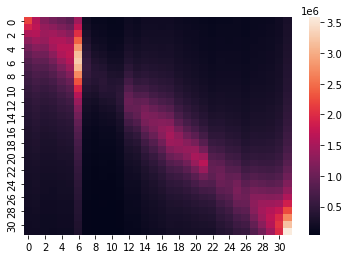

In [ ]:
p2 = sns.heatmap(T)

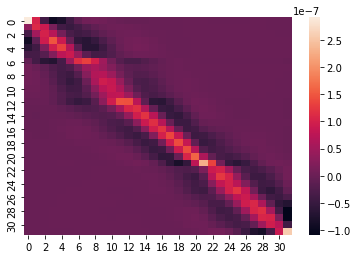

In [ ]:
import seaborn as sns
p2 = sns.heatmap(T_reg)

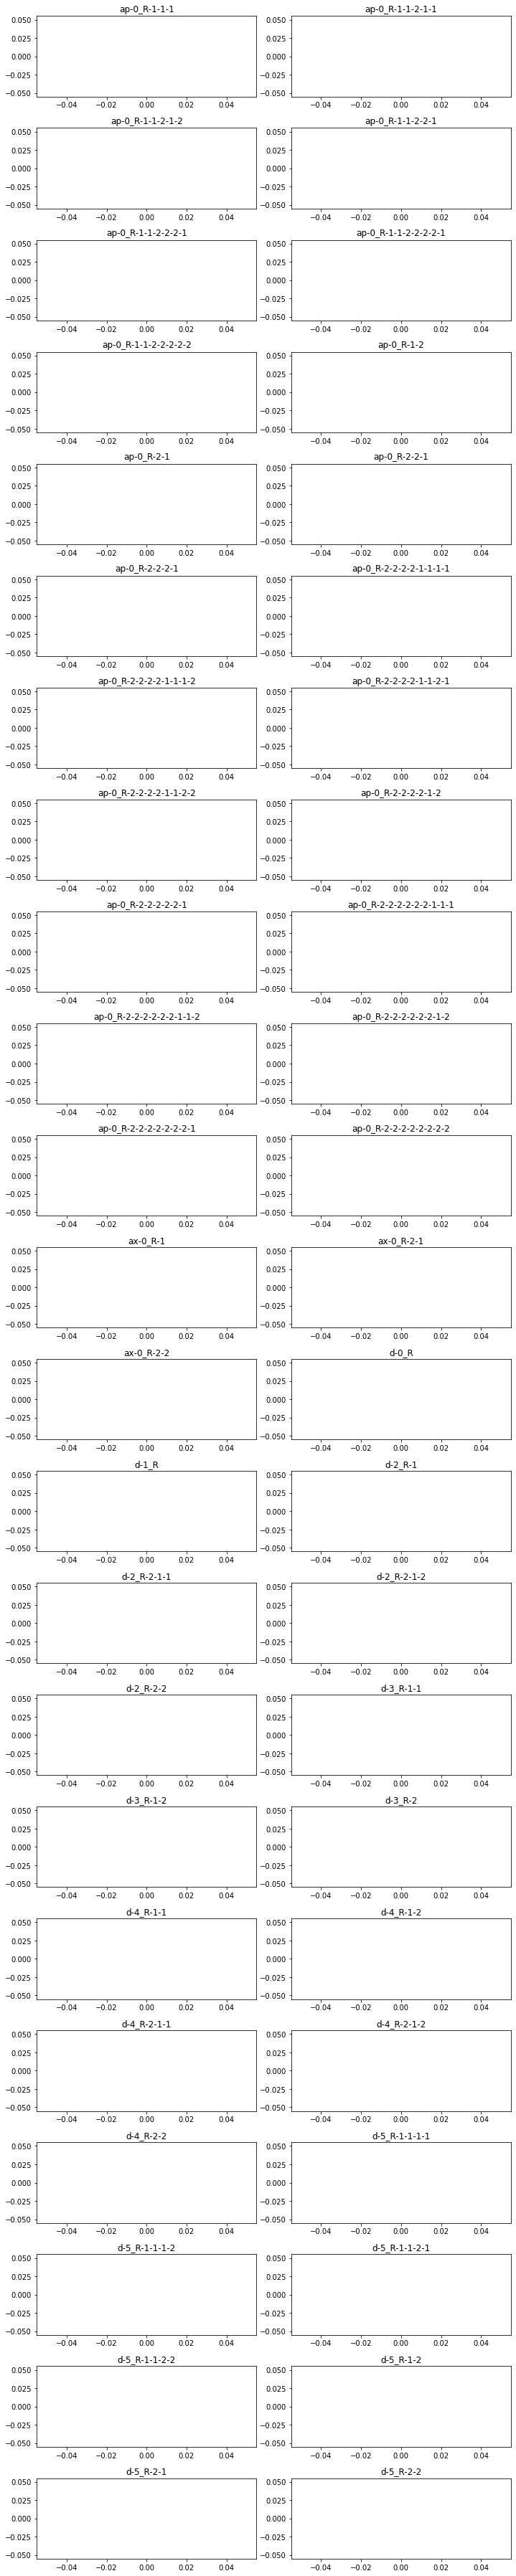

In [ ]:
# ez önmagában nem csinál semmit
# ahhoz, hogy ez működjön a számolást csak 1 időpillanatra szabad futtatni, 
# ha kell, megmutatom

endparts = []
for part in Map: # ez csak felépíti az ábrázolható anyagot
  if part != 'CellBody':
    if (part + '-1') in Cell.keys():
      pass
    elif (part + '-2') in Cell.keys():
      pass
    else: endparts.append(part)

data = []
for prt in endparts:
  c = prt.count('-')
  #print(prt)
  #print(c)
  dat = []
  for i in range(c):
    #print(i)
    #print(prt)
    dat.insert(0,Cell[prt]["f_int"])
    if i != c-1: 
      prt = prt[:-2]
  data.append(dat)

fig, axis = plt.subplots(23, 2, figsize=[10,50])
k = 0
for i in range(23):
  for j in range(2):
    n = 0
    for e in data[0]:
      axis[i, j].scatter(n + np.array(range(len(e))),e, s = 4)
      n += len(e)
    axis[i, j].set_title(endparts[k])
    k += 1
    data.pop(0)

plt.tight_layout()
plt.show()

#Plotting
First of all we import a list of RGB colors, then scaled to global minimum and maximum values the given voltage or current data is represented.

In [ ]:
# read list of 90 rgb colors
def read_rgb90(filename):
  #90-es rgb list
  data, rgb90 = [], []
  for line in open(filename): 
    line = line.rstrip("").split(" ")
    for i in range(len(line)):
      line[i] = float(line[i])
    data.append(line)
  for i in range(len(data)):
    rgb90.append(data[i])
  rgb90 = rgb90[::-1]
  return rgb90

##Estimating membrane potential

In [ ]:
# color scale for membrane potential
def color_scale_V_M(V_min, V_max, V):
  if V < -30000: 
    return int(round((22 * (1/np.abs(V_min) * V) + 22), 3))
  if V >= -30000: 
    return int(round((24 * (1/V_max * V) + 24), 3))

# find maximal and minimal Voltage
def find_glob_extreme_V_M(M_P):
  vmin, vmax = 0, 0 
  V_min = M_P[0][0][2]
  V_max = M_P[0][0][2]  

  for t in range(len(M_P)):
    for d in range(len(M_P[t])):
        if M_P[t][d][2] < V_min:
          V_min = M_P[t][d][2]
          vmin = str(t) + "-" + str(d) + "-th compartment"
        if V_max < M_P[t][d][2]:
          V_max = M_P[t][d][2]
          vmax = str(t) + "-" + str(d) + "-th compartment" 
  V_min = min(min(Vc), V_min)
  V_max = max(max(Vc), V_max)
  print("V_max = " + str(V_max))
  print("V_min = " + str(V_min))
  print(vmin)
  print(vmax)
  return [V_min, V_max]

arg_mp = M_P
argstr_mp = "V_M"
colors = read_rgb90("RGBScale.txt")
colors = colors[40 :]
V_min, V_max = find_glob_extreme_V_M(arg_mp)

In [ ]:
#plotting membrane potential
plt.ioff()
x_soma = Cell["CellBody"]['coords'][0][0]
y_soma = Cell["CellBody"]['coords'][0][1]
z_soma = Cell["CellBody"]['coords'][0][2]
d_soma = Cell["CellBody"]['coords'][0][3]
for k in [100]:
  fig = plt.figure(figsize=(32,16))
  ax = plt.axes(projection='3d')
  ax.set_xlabel('X ($\mu m$)')
  ax.set_ylabel('Y ($\mu m$)')
  ax.set_zlabel('Z ($\mu m$)') 
  for mp in arg_mp[k]:
    x1 = mp[0][0]
    x2 = mp[1][0] 
    y1 = mp[0][1]
    y2 = mp[1][1]
    z1 = mp[0][2]
    z2 = mp[1][2]
    d1 = mp[0][3]
    d2 = mp[1][3]
    col = color_scale_V_M(V_min, V_max, mp[2])
    ax.scatter3D(x_soma, y_soma, z_soma, linewidth=d_soma, marker="*", color=colors[col])
    ax.plot3D([x1,x2], [y1,y2], [z1,z2], linewidth=2.5*(d1+d2)/2, c=colors[col])
'''  images_dir = 'sp9_snapshots/sp9_' + f"{argstr_mp}"
  if k < 100 and k >= 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr_mp}_0" + str(k+1), dpi=300)
  elif k < 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr_mp}_00" + str(k+1), dpi=300)
  else: fig.savefig(f"{images_dir}/sp9_" + f"{argstr_mp}_" + str(k+1), dpi=300) 
'''  #plt.close(fig)

In [ ]:
M_P[110][1100]

## Plotting functions

In [ ]:
# non-linear color scaling
def color_scale(V_min, V_max, V):
  if V <= 0: 
    return int(round((45 * np.cbrt(1/np.abs(V_min) * V) + 45), 4))
  if V > 0: 
    return int(round((44 * np.cbrt(1/np.abs(V_max) * V) + 44), 4))

# find maximal and minimal Values
def find_glob_extreme(M_P):
  vmin, vmax = 0, 0 
  V_min = M_P[0][0][2]
  V_max = M_P[0][0][2]  
  for t in range(len(M_P)):
    for d in range(len(M_P[t])):
        if M_P[t][d][2] < V_min:
          V_min = M_P[t][d][2]
          vmin = str(t) + "-" + str(d) + "-th compartment"
        if V_max < M_P[t][d][2]:
          V_max = M_P[t][d][2]
          vmax = str(t) + "-" + str(d) + "-th compartment"
  V_max=max(np.abs(V_max), np.abs(V_min))
  V_min= -V_max
  print("V_max = " + str(V_max))
  print("V_min = " + str(V_min))
  print(vmin)
  print(vmax)
  return [V_min, V_max]

Argument can be V_EC, CSD_mtx, I_M, I_R or I_C.

In [ ]:
arg = CSD_mtx
argstr = "siCSD"
colors = read_rgb90("RGBScale.txt")
V_min, V_max = find_glob_extreme(arg)

In [ ]:
#NEURON FROM A STRANGE PERSPECTIVE
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.ioff()
x_soma = Cell["CellBody"]['coords'][0][0]
y_soma = Cell["CellBody"]['coords'][0][1]
z_soma = Cell["CellBody"]['coords'][0][2]
d_soma = Cell["CellBody"]['coords'][0][3]
for k in range(len(arg)): #[94, 101, 127]:
  fig = plt.figure(figsize=(32,16))
  ax = plt.axes(projection='3d')
  #ax.view_init(0, -90)
  ax.set_xlabel('X ($\mu m$)')
  ax.set_ylabel('Y ($\mu m$)')
  ax.set_zlabel('Z ($\mu m$)')
  for mp in arg[k]:
    x1 = mp[0][0]
    x2 = mp[1][0] 
    y1 = mp[0][1]
    y2 = mp[1][1]
    z1 = mp[0][2]
    z2 = mp[1][2]
    d1 = mp[0][3]
    d2 = mp[1][3]
    col = color_scale(V_min, V_max, mp[2])
    ax.scatter3D(x_soma, y_soma, z_soma, linewidth=d_soma, marker="*", color=colors[col])
    ax.plot3D([x1,x2], [y1,y2], [z1,z2], linewidth=2.5*(d1+d2)/2, c=colors[col])
  images_dir = 'sp9_snapshots/sp9_' + f"{argstr}"
  if k < 100 and k >= 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr}_0" + str(k+1), dpi=300)
  elif k < 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr}_00" + str(k+1), dpi=300)
  else: fig.savefig(f"{images_dir}/sp9_" + f"{argstr}_" + str(k+1), dpi=300) 
  plt.close(fig)